# Grad-CAM

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import argparse
import matplotlib.pyplot as plt
from torchvision import models, transforms
from techniques.grad_cam import GradCAM, BackPropagation, GuidedBackPropagation
from techniques.grad_cam import (get_gradCAM_img,preprocess_image, get_guidedBackProp_img, split_gradCAM, get_pred)
from skimage import io
import cv2
import os
import random
from torch.autograd import Variable
from PIL import Image

In [2]:
## Tiny ImageNet Test Set

In [15]:
paths = []
for r, d, f in os.walk('../data/ILSVRC2012_img_val/'):
    for file in f:
        if '.JPEG' in file:
            paths.append(os.path.join(r, file))
random.shuffle(paths)
data_iter = iter(paths)
print(len(paths))

47779


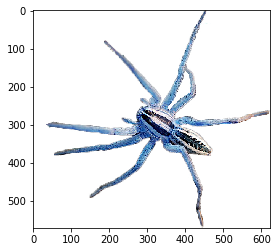

In [16]:
path1 = next(data_iter)
if os.path.isfile(path1):
    img1 = cv2.imread(path1, 0)
else:
    print ("The file " + path1 + " does not exist.")
img = cv2.imread(path1)
plt.imshow(img)

False
[0.54998] wolf_spider


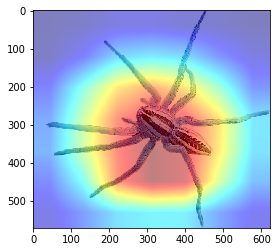

In [18]:
#get heatmap of image using gradcam given an image path, model name, number of categories, 
#and an alternate layer (optional; otherwise will just use the last conv layer)
heatmap, result, weight= get_gradCAM_img(path1, 'resnet18', 1)

## Miou

In [19]:
# mean interesection of union
def miou(images):
    s = 0
    for image in images:
        s += iou(image)
    return s/len(images)
    
# intersection of union
def iou(img_path, rec = 1):
    masks = []
    miou_class = get_pred(img_path, 'resnet18', rec)[rec-1]
    print(miou_class)
    for model in ['resnet18', 'resnet152', 'vgg19']:
        max_count = 10
        y = 1
        pred = get_pred(img_path, model, num=y)[y-1]
        while miou_class != pred:
            if y > max_count:
                print("recurse")
                return iou(img_path, rec+1)
            print("Pred: {0}, Model: {1}".format(pred, model))
            y  = y+1
            pred = get_pred(img_path, model, num=y)[y-1]
        heatmap, cam, prob = get_gradCAM_img(img_path, model, y, show=False)
        hsv = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)
        masks += [cv2.inRange(hsv, (15,0,0), (140,255,255))]
    img = cv2.imread(img_path)
    union = None
    intersection = None
    flag = False
    for mask in masks:
        if not flag:
            union = mask
            intersection = mask
            flag = True
        else:
            union[mask == 0] = 0
            intersection = np.add(union, mask)
    for mask in masks:
        img[mask == 0] = img[mask==0].mean(axis=0)
    return len(intersection[intersection == 0])/len(union[union == 0])
    

In [20]:
paths = []
for r, d, f in os.walk('tiny-imagenet-200/train/'):
    for file in f:
        if '.JPEG' in file:
            paths.append(os.path.join(r, file))
random.shuffle(paths)

In [11]:
import glob
paths = glob.glob(os.path.join('tiny-imagenet-200/train/*/images/', "*/*.JPEG"), recursive=True)

In [20]:
files = []
for r, d, f in os.walk('tiny-imagenet-200/train/'):
    for file in f:
        if '.JPEG' in file:
            files.append(os.path.join(r, file))
len(files)

100000

[0.77716] barrel


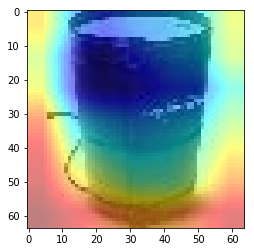

In [21]:
heatmap, result, weight = get_gradCAM_img(files[0], 'resnet18', 1)

[0.66041] barrel


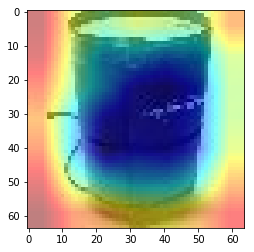

In [22]:
heatmap, result, weight = get_gradCAM_img(files[0], 'resnet152', 1)

[0.59872] barrel


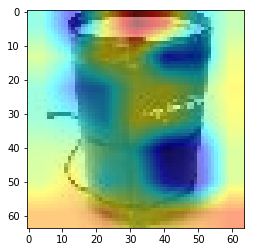

In [23]:
heatmap, result, weight = get_gradCAM_img(files[0], 'vgg19', 1)

## Blurring Images

In [31]:
#blurring out the blue in the heatmap 
def blur_img(img_path):
    heatmap, cam, prob = get_gradCAM_img(img_path, 'resnet18', 1)
    hsv = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (15,0,0), (140,255,255))
    img = cv2.imread(img_path)
    img[mask == 0] = img[mask==0].mean(axis=0)
    plt.imshow(img)
    return img

[0.97110] bee
[0.01111] grasshopper
[0.00598] cricket


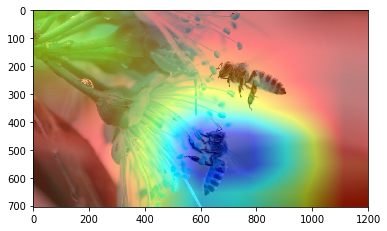

In [32]:
heatmap, cam, weight= get_gradCAM_img('samples/bees.jpg', 'resnet152', 3)

[0.74863] ant


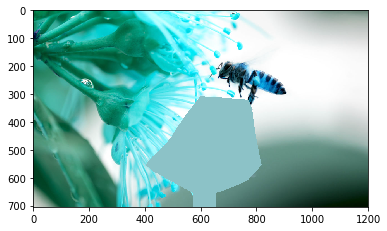

In [33]:
img = blur_img('samples/bees.jpg')

Generating gradcam heatmap, blurring out the important class, and then rerunning gradcam until the softmax probability is low, combining all nthe heatmaps 

In [26]:
def blur(img, prob, heatmap, orig, num):
    if prob < .3 or num == 24:
        heatmap = cv2.applyColorMap(np.uint8(heatmap*225.0), cv2.COLORMAP_JET)
        img2 = cv2.resize(orig, (224,224))
        cam = np.float32(img2)
        cam = heatmap + cam
        cam = cam / np.max(cam)
        plt.imshow(cam)
        return
    img = cv2.resize(img, (224,224))
    hm, result, weight = get_gradCAM_img2(img, 'resnet18', 1)
    hsv = cv2.cvtColor(hm, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (15,0,0), (140,255,255))
    img[mask == 0] = img[mask==0].mean(axis=0)
    heatmap = heatmap + result
    heatmap = heatmap/np.max(heatmap)
    return blur(img, weight, heatmap, orig, num+1)

[0.62212] cheetah
[0.96124] zebra
[0.28211] balloon


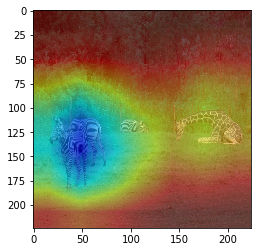

In [27]:
orig = cv2.imread('samples/zebras.jpg', 1)
heatmap = np.zeros((224,224))
blur(orig, 1, heatmap, orig, 0)

Generate heat map by most likely class, then combine it with the heatmap from the second most likely class (normalizing as you go), and so on until the softmax probability is below a threshhold 

In [52]:
def combine(img_path):
    n = 1
    prob = 1
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    heatmap = np.zeros((h,w))
    while prob > .2:
        hm, result, weight = get_gradCAM_img(img_path, 'resnet18', n)
        heatmap = heatmap + result
        heatmap = heatmap/np.max(heatmap)
        n = n+1
        prob = weight
    heatmap = cv2.applyColorMap(np.uint8(heatmap*225.0), cv2.COLORMAP_JET)
    cam = np.float32(img)
    cam = heatmap + cam
    cam = cam / np.max(cam)
    plt.imshow(cam)

[0.42589] boxer
[0.42589] boxer
[0.26502] bull_mastiff
[0.42589] boxer
[0.26502] bull_mastiff
[0.17546] tiger_cat


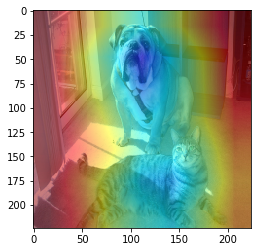

In [53]:
combine('samples/cat_dog.png')

## Guided Backprop

In [6]:
import saliency
from matplotlib import pylab as P
def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


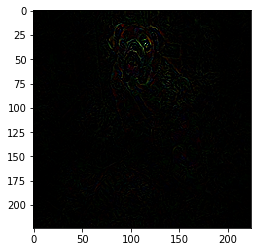

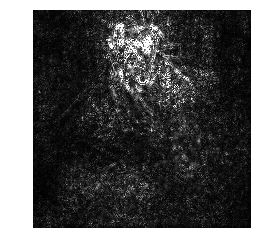

In [10]:
feature = get_guidedBackProp_img('data/samples/cat_dog.png', 'resnet18', 1)
gray = saliency.VisualizeImageGrayscale(feature)
ShowGrayscaleImage(gray)

## Weighting by Crappy Softmax/Bounding Boxes

[0.50849] wallaby
[0.26894] wood_rabbit
0.26894388


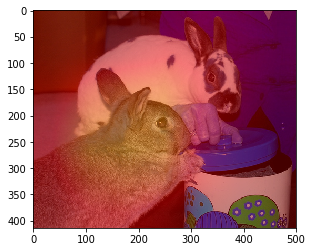

In [22]:
#gradCAM weighted by the class probability 
heatmap, cam, weight= get_gradCAM_img('samples/bunnies.jpg', 'resnet18', 2, weight = True)
print(weight)

[0.03477] dugong
[0.17416] Sealyham_terrier
[0.63072] toy_terrier
[0.20852] sweatshirt
[0.19323] wire-haired_fox_terrier
[0.56518] German_shepherd
[0.18826] toy_terrier
[0.11646] Saint_Bernard
[0.12253] fox_squirrel
[0.30543] fox_squirrel
[0.18008] Norwegian_elkhound
[0.07287] potter's_wheel
[0.07492] fox_squirrel
[0.14523] badger
[0.34107] Bedlington_terrier
[0.21207] pick


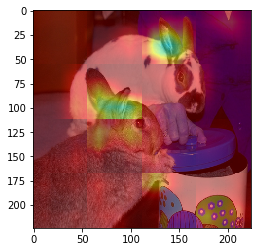

In [53]:
#splits the image uniformly into sections and runs weighted gradcam on each section
split_gradCAM('samples/bunnies.jpg', 4)

In [13]:
def sliding_window(image_path, stepSize, windows):
    # slide a window across the image
    img = cv2.imread(image_path, 1)
    img2 = cv2.resize(img, (224,224))
    hm = np.zeros((224,224))
    cam = np.float32(img2)
    cam = cam *2
    for y in range(0, img2.shape[0], stepSize):
        for x in range(0, img2.shape[1], stepSize):
            # yield the current window
            #windows = [[128,64]]
            for window in windows:
                if (y+window[1] <= 224 or x+window[0] <= 224):
                    img_slice = img2[y:y + window[1], x:x + window[0]]
                    heatmap, result = get_gradCAM_img2(img_slice, 'resnet18', 1, weight = True)
                    hm[y:y + window[1], x:x + window[0]] = hm[y:y + window[1], x:x + window[0]] + result
                    hm[y:y + window[1], x:x + window[0]] = hm[y:y + window[1], x:x + window[0]]/np.max(hm[y:y + window[1], x:x + window[0]])
                #ret.append((x, y, image[y:y + windowSize[1], x:x + windowSize[0]]))
    #cam = cam/np.max(cam)
    #plt.imshow(cam)
    hm2 = cv2.applyColorMap(np.uint8(hm*225.0), cv2.COLORMAP_JET)
    cam = cam + hm2
    cam= cam/np.max(cam)
    result = cv2.addWeighted(img2, .4, hm2, .6, 0)
    plt.imshow(result)
    return hm

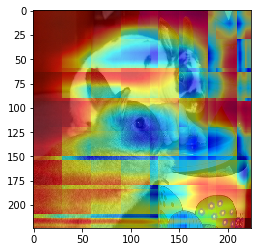

In [3]:
gen = sliding_window('samples/bunnies.jpg', 30, [[128,64]])

In [ ]:
gen = sliding_window('samples/bunnies.jpg', 30, [[200,200]])

In [27]:
def random_pred(image_path, num_samples, windows):
    #windows = [[128, 128], [128,64]]
    img = cv2.imread(image_path, 1)
    img2 = cv2.resize(img, (224,224))
    hm = np.zeros((224,224))
    cam = np.float32(img2)
    cam = cam *2
    for i in range(num_samples):
        x = np.random.randint(0, 224+1)
        y = np.random.randint(0,224+1)
        for window in windows:
            if (y+window[1] <= 224 or x+window[0] <= 224):
                    img_slice = img2[y:y + window[1], x:x + window[0]]
                    heatmap, result, weight = get_gradCAM_img2(img_slice, 'resnet18', 1, weight = True)
                    if weight > .2:
                        hm[y:y + window[1], x:x + window[0]] = hm[y:y + window[1], x:x + window[0]] + result
                        hm[y:y + window[1], x:x + window[0]] = hm[y:y + window[1], x:x + window[0]]/np.max(hm[y:y + window[1], x:x + window[0]])
    hm2 = cv2.applyColorMap(np.uint8(hm*225.0), cv2.COLORMAP_JET)
    cam = cam + hm2
    cam= cam/np.max(cam)
    result = cv2.addWeighted(img2, .4, hm2, .6, 0)
    plt.imshow(result)
    return hm

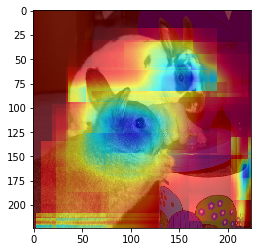

In [28]:
#128by128
hm = random_pred('samples/bunnies.jpg', 50, [[128,128], [128, 64]])

Black box thing

In [2]:
def black_box(image_path, stepSize, windows, label):
    # slide a window across the image
    img = cv2.imread(image_path, 1)
    img2 = cv2.resize(img, (224,224))
    orig = get_pred2(img2, 'resnet18')[0]
    for window in windows:
        for y in range(0, img2.shape[0], stepSize):
            for x in range(0, img2.shape[1], stepSize):
                # yield the current window
                #windows = [[128,64]]
                copy = cv2.resize(img, (224,224))
                if (y+window[1] <= 224 and x+window[0] <= 224):
                    copy[y:y + window[1], x:x + window[0]] = np.zeros((window[1], window[0], 3))
                    if orig != get_pred2(copy, 'resnet18')[0]:
                        print(get_pred2(copy, 'resnet18')[1])
                        plt.imshow(copy)
                        return "done"
    print("didnt work")
    return img2

guinea_pig


'done'

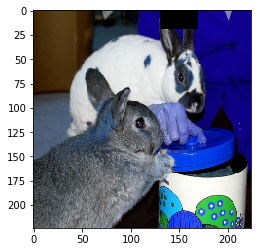

In [3]:
black_box('samples/bunnies.jpg', 10, [[40,20], [40, 40], [80,40], [40,80], [60, 60], [100,100], [200,100]], 331)

In [ ]:
black_box('samples/hampster.jpg', 10, [[5, 5], [5, 10], [10,5], [10,10], [10,20], [20,10], [40,20], [40, 40], [80,40], [40,80], [60, 60], [100,100], [200,100]], 331)